In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import pandas as pd
import os
import sys
import pathlib
import functools
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchvision.transforms import *
import time
from tqdm import tqdm

In [2]:
sys.path.insert(0,'/home')
from data import HCP_MRI_reshape
import grad_cam

In [3]:

random.seed(82)
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# CHECKPOINTS_DIR = '/home/Druzhinina/project/checkpoints_skull/' #best_acc_model_NetGradRandomiz_all_subject_bs42
CHECKPOINTS_DIR = '/home/checkpoints_torchion_reshape'

In [4]:
# print(X.shape, y.shape)

In [5]:
# PATH_TO_MRI = '/data/hcp/HCP_T1_pm'
data_dir = pathlib.Path('/data/adni')
behavioral_path = os.path.join('/data/adni', 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'
PATH_TO_MRI = '/home/crop_data_resize'

HCP absmax before normalization: 435.0126647949219
Dataset size: 223
Labels distribution: (array([0, 1]), array([113, 110]))

Example:
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


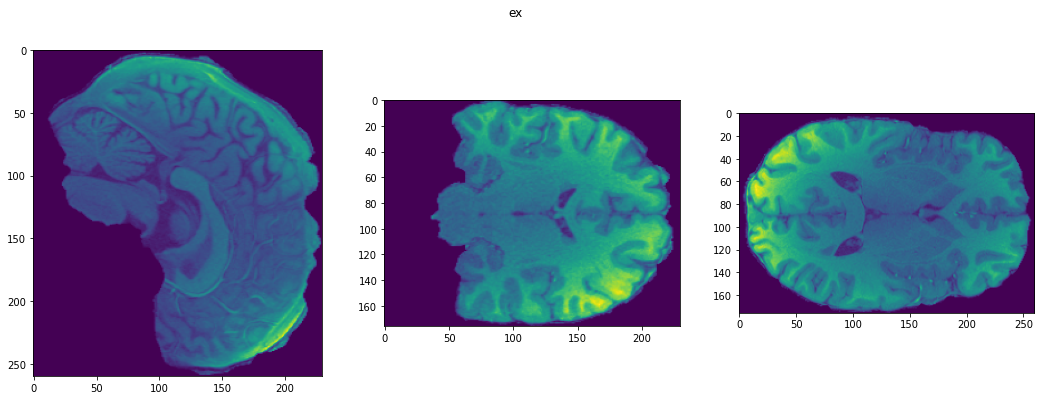

In [6]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
X_train, X_test = train_test_split(pd.read_csv(behavioral_path), test_size=0.2, shuffle=False) 
hcp_dataset = HCP_MRI_reshape(
    paths= PATH_TO_MRI,
    target_path= X_test, #[1113//2:
    load_online=True,
    hcp_type = hcp_type,
#     coord_min=(40,25,55),
    coord_min=(40, 40, 30, 30, 45, 45),
    img_shape=(176, 260, 230)
)
hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)

transform = Compose([
#     BrightnessContrast(),
#     GaussNoise(),
#     Rotate(),
    ToTensor(),
])
hcp_dataset.transform = transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Dataset size: {}".format(len(hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(hcp_dataset.labels, return_counts=True)))

print("Example:")
img, target = hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [7]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2,),
                
                nn.Conv3d(c, 2*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1896960, out_features=2), #4*c*5*7*5
        )
        self.gradients = None
        
     
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)


In [8]:
!nvidia-smi

Sun Apr  4 15:19:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:05:00.0 Off |                    0 |
| N/A   38C    P0    34W / 250W |  11915MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:08:00.0 Off |                    0 |
| N/A   34C    P0    34W / 250W |   1740MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [9]:
if torch.cuda.is_available():
  device = torch.device("cuda:7")
else:
  device = torch.device("cpu")

if torch.cuda.device_count() > 1:
      d_ids= [7,5]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

Let's use [7, 5] GPUs!


In [10]:
def get_prediction(net, data_loader, device):
    net.eval()
    pred_list = []
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred_list.append(out.data.max(1)[1].detach().cpu().numpy()) 
        del data, target,out
    return pred_list

In [11]:
torch.cuda.empty_cache()

In [12]:
hcp_dataset[0][0].shape[1:]

torch.Size([176, 260, 230])

In [13]:
# model = model.to(device) 
# model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model__checkpoints_crop_scale'), map_location=device))
# model.eval()
# loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, np.arange(len(hcp_dataset)//2)), batch_size=1, shuffle=False)
# pr = get_prediction(model, loader, device)

In [14]:
np.concatenate(masks,axis=0).squeeze(axis=1)

NameError: name 'masks' is not defined

In [13]:
isTrain = True

In [14]:
if isTrain:
    mask = []
    model = model.to(device) 
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model__checkpoints_torchio_reshape'), map_location=device))
#     model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'checkpoints_augment_rot_55best_acc_model__checkpoints_augment_18_1.2'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(hcp_dataset,
                                          shuffle=False,
                                          batch_size=128)
#     i = 5
#     for data,_ in tqdm(loader):
# #         masks_grad = grad_cam.get_masks(model.module, data, device, mask_type='grad_cam', size=hcp_dataset[0][0].shape[1:])
#         masks_grad = grad_cam.get_masks(model.module, data, device, mask_type='grad_cam', size=hcp_dataset[0][0].shape[1:], os.path.join(CHECKPOINTS_DIR,'Fold_{}'.format(i)))
#         np.save(os.path.join(CHECKPOINTS_DIR,'masks_grad_cam_test_{}'.format(i)), masks_grad)
# #         mask.append(masks_grad)
#         i +=1
        
else:
    masks_grad1 = np.load(os.path.join(CHECKPOINTS_DIR, 'masks_grad_cam_part1_hardcod.npy'))

In [15]:
loader.dataset.mri_paths

['/home/crop_data_resize/871762_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/845458_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/729254_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/957974_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/788674_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/987983_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/727654_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/792766_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/919966_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/896778_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/942658_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/891667_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/878776_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/683256_3T_T1w_MPR1_bet_mask_crop.nii.gz',
 '/home/crop_data_resize/832651_3T_T1w_MPR1_bet_mask_crop.nii.

In [37]:
sys.getsizeof(img)

1347174544

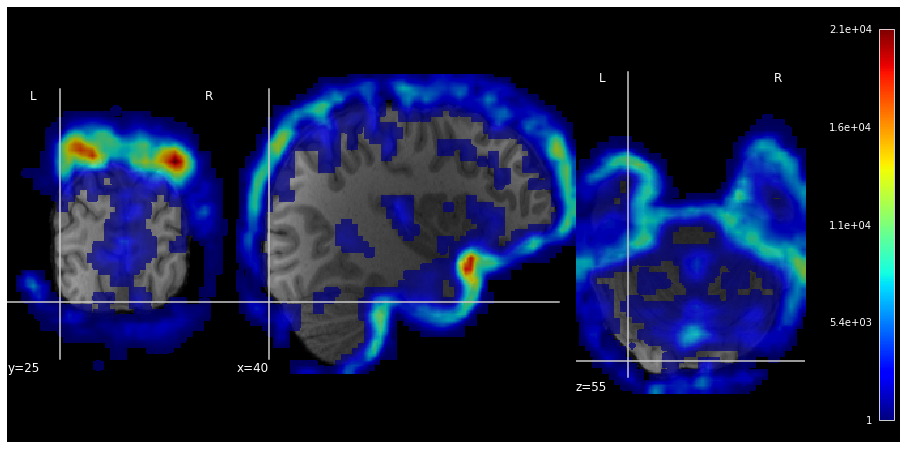

In [39]:
fig, axes = plt.subplots(figsize=(16,8))
roi_img = nib.Nifti1Image(masks_grad,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[0][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img, cut_coords = (40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()

# Train mult grad_cam

In [11]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
def get_metric_perturb_mask(net, data_loader, masks):
    net.eval()
    correct = 0
    true = []
    i = 0
    k = 0
    for data, target in tqdm(data_loader):
        mask[i][k][mask[i][k] == 0] =1
        data = data.mul(torch.from_numpy(mask[i][k])).to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        true.append(pred.data.cpu().numpy())
        correct += pred.eq(target.data).cpu().sum()
        k +=1
        if k > 127:
            i +=1
            k = 0
        del data, target, out, pred
    accuracy = 100. * correct / len(data_loader.dataset)
    true = np.concatenate(true)
    roc_auc = roc_auc_score(data_loader.dataset.labels, true)
    pr = precision_score(data_loader.dataset.labels,  true)
    rec = recall_score(data_loader.dataset.labels, true)

    return accuracy.item(), roc_auc, pr, rec

In [7]:
pip install seaborn

     |████████████████████████████████| 285 kB 4.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

(128, 176, 260, 230)
3


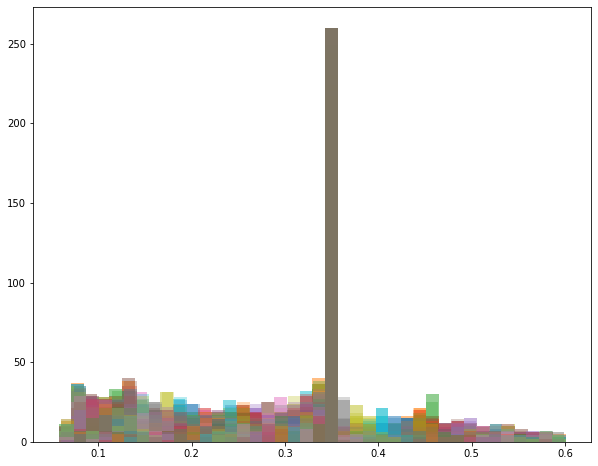

In [9]:
mask = []
i =0
for each in os.listdir(CHECKPOINTS_DIR):
    if 'train' in each:
        mask.append(np.load(os.path.join(CHECKPOINTS_DIR,each)))
        if i ==2:
            print(mask[i].shape)
            mask_mean = mask[i].mean(axis=0)
            amax = np.max( mask_mean)
            amin = np.min( mask_mean)
            rang = amax-amin
            norm_arr = ((mask_mean - amin)/rang)
    #         norm_arr = preprocessing.normalize(mask_mean)
    #         sns.distplot(norm_arr, hist =True, kde=False, color = 'blue', hist_kws={'edgecolor':'black'})
            fig = plt.figure(figsize=(10,8))
    #         ax = fig.gca(projection='3d')
    #         ax.bar3d(norm_arr[0], norm_arr[1], norm_arr[2])
    #         hist = C.Histogram2d(norm_arr[0], norm_arr[1], norm_arr[2])
    #         hist.hist.hist.plot_surface(cmap='vir')
            kw = dict(histtype = 'stepfilled', alpha=0.3, bins=40)
            plt.hist(norm_arr[0], **kw)
            plt.hist(norm_arr[1], **kw)
            plt.hist(norm_arr[2], **kw)
            break
        i+=1
# np.concatenate(mask,axis=0).squeeze(axis=1)
print(len(mask))

(128, 176, 260, 230)
1


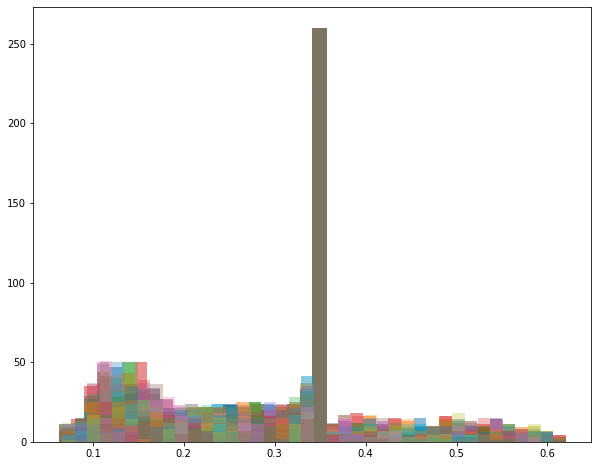

In [28]:
mask = []
i =0
for each in os.listdir(CHECKPOINTS_DIR):
    if 'train' in each:
        mask.append(np.load(os.path.join(CHECKPOINTS_DIR,each)))
        print(mask[i].shape)
        mask_mean = mask[i].mean(axis=0)
        amax = np.max( mask_mean)
        amin = np.min( mask_mean)
        rang = amax-amin
        norm_arr = ((mask_mean - amin)/rang)
#         norm_arr = preprocessing.normalize(mask_mean)
#         sns.distplot(norm_arr, hist =True, kde=False, color = 'blue', hist_kws={'edgecolor':'black'})
        fig = plt.figure(figsize=(10,8))
#         ax = fig.gca(projection='3d')
#         ax.bar3d(norm_arr[0], norm_arr[1], norm_arr[2])
#         hist = C.Histogram2d(norm_arr[0], norm_arr[1], norm_arr[2])
#         hist.hist.hist.plot_surface(cmap='vir')
        kw = dict(histtype = 'stepfilled', alpha=0.3, bins=40)
        plt.hist(norm_arr[0], **kw)
        plt.hist(norm_arr[1], **kw)
        plt.hist(norm_arr[2], **kw)
        i+=1
        break
# np.concatenate(mask,axis=0).squeeze(axis=1)
print(len(mask))

(128, 176, 260, 230)
1


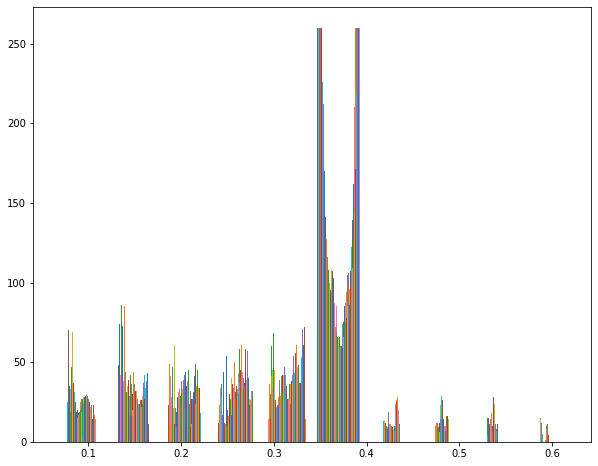

In [25]:
mask = []
i =0
for each in os.listdir(CHECKPOINTS_DIR):
    if 'train' in each:
        mask.append(np.load(os.path.join(CHECKPOINTS_DIR,each)))
        print(mask[i].shape)
        mask_mean = mask[i].mean(axis=0)
        amax = np.max( mask_mean)
        amin = np.min( mask_mean)
        rang = amax-amin
        norm_arr = ((mask_mean - amin)/rang)
#         norm_arr = preprocessing.normalize(mask_mean)
#         sns.distplot(norm_arr, hist =True, kde=False, color = 'blue', hist_kws={'edgecolor':'black'})
        fig = plt.figure(figsize=(10,8))
#         ax = fig.gca(projection='3d')
#         ax.bar3d(norm_arr[0], norm_arr[1], norm_arr[2])
#         hist = C.Histogram2d(norm_arr[0], norm_arr[1], norm_arr[2])
#         hist.hist.hist.plot_surface(cmap='vir')
        plt.hist(norm_arr[0])
        plt.hist(norm_arr[1])
        plt.hist(norm_arr[2])
        i+=1
        break
# np.concatenate(mask,axis=0).squeeze(axis=1)
print(len(mask))

(128, 176, 260, 230)
1


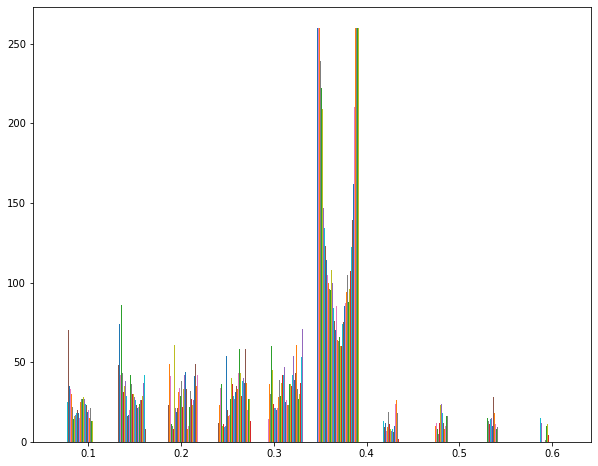

In [24]:
mask = []
i =0
for each in os.listdir(CHECKPOINTS_DIR):
    if 'train' in each:
        mask.append(np.load(os.path.join(CHECKPOINTS_DIR,each)))
        print(mask[i].shape)
        mask_mean = mask[i].mean(axis=0)
        amax = np.max( mask_mean)
        amin = np.min( mask_mean)
        rang = amax-amin
        norm_arr = ((mask_mean - amin)/rang)
#         norm_arr = preprocessing.normalize(mask_mean)
#         sns.distplot(norm_arr, hist =True, kde=False, color = 'blue', hist_kws={'edgecolor':'black'})
        fig = plt.figure(figsize=(10,8))
#         ax = fig.gca(projection='3d')
#         ax.bar3d(norm_arr[0], norm_arr[1], norm_arr[2])
#         hist = C.Histogram2d(norm_arr[0], norm_arr[1], norm_arr[2])
#         hist.hist.hist.plot_surface(cmap='vir')
        plt.hist(norm_arr[0])
#         plt.hist(norm_arr[1])
#         plt.hist(norm_arr[2])
        i+=1
        break
# np.concatenate(mask,axis=0).squeeze(axis=1)
print(len(mask))

(128, 176, 260, 230)
1


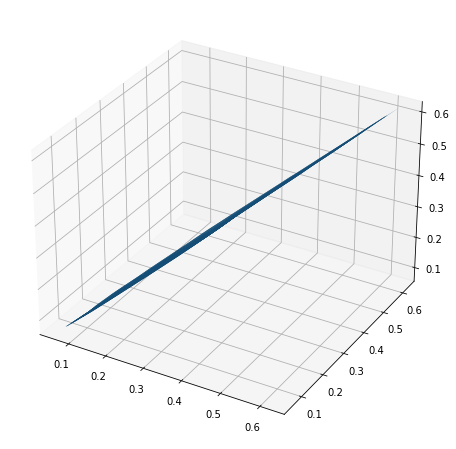

In [12]:
mask = []
i =0
for each in os.listdir(CHECKPOINTS_DIR):
    if 'train' in each:
        mask.append(np.load(os.path.join(CHECKPOINTS_DIR,each)))
        print(mask[i].shape)
        mask_mean = mask[i].mean(axis=0)
        amax = np.max( mask_mean)
        amin = np.min( mask_mean)
        rang = amax-amin
        norm_arr = ((mask_mean - amin)/rang)
#         norm_arr = preprocessing.normalize(mask_mean)
#         sns.distplot(norm_arr, hist =True, kde=False, color = 'blue', hist_kws={'edgecolor':'black'})
        fig = plt.figure(figsize=(10,8))
        ax = fig.gca(projection='3d')
#         ax.bar3d(norm_arr[0], norm_arr[1], norm_arr[2])
        ax.plot_surface(norm_arr[0], norm_arr[1], norm_arr[2])
        i+=1
        break
# np.concatenate(mask,axis=0).squeeze(axis=1)
print(len(mask))

In [34]:
a = [6,9,2,4,5,7,5,8]
amax= np.max(a)
amin = np.min(a)
rang = amax - amin
morm=((a-amin)/rang)

In [35]:
morm

array([0.57142857, 1.        , 0.        , 0.28571429, 0.42857143,
       0.71428571, 0.42857143, 0.85714286])

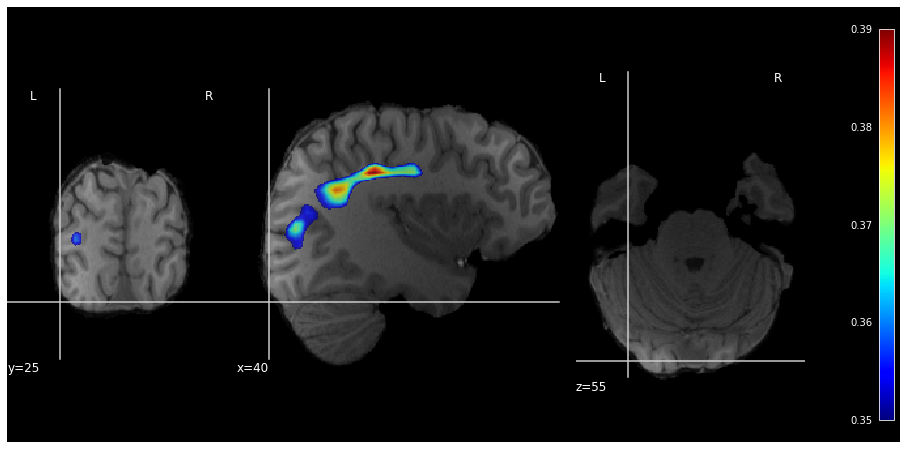

In [37]:
fig, axes = plt.subplots(figsize=(16,8))
roi_img = nib.Nifti1Image(mask_mean,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[0][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img, cut_coords = (40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()

In [21]:
mask_mean.shape

(176, 260, 230)

In [20]:
mask_mean

array([[[0.14413455, 0.14413455, 0.14413455, ..., 0.14413455,
         0.14413455, 0.14413455],
        [0.14413455, 0.14413455, 0.14413455, ..., 0.14413455,
         0.14413455, 0.14413455],
        [0.14413455, 0.14413455, 0.14413455, ..., 0.14413455,
         0.14413455, 0.14413455],
        ...,
        [0.14413455, 0.14413455, 0.14413455, ..., 0.14413455,
         0.14413455, 0.14413455],
        [0.14413455, 0.14413455, 0.14413455, ..., 0.14413455,
         0.14413455, 0.14413455],
        [0.14413455, 0.14413455, 0.14413455, ..., 0.14413455,
         0.14413455, 0.14413455]],

       [[0.14413455, 0.14413455, 0.14413455, ..., 0.14413455,
         0.14413455, 0.14413455],
        [0.14413455, 0.14413455, 0.14413455, ..., 0.14413455,
         0.14413455, 0.14413455],
        [0.14413455, 0.14413455, 0.14413455, ..., 0.14413455,
         0.14413455, 0.14413455],
        ...,
        [0.14413455, 0.14413455, 0.14413455, ..., 0.14413455,
         0.14413455, 0.14413455],
        [0.1

In [ ]:
np.concatenate(mask,axis=0).squeeze(axis=1)

In [14]:
# mask = []
model = model.to(device) 
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model__checkpoints_torchio_reshape'), map_location=device))
#     model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'checkpoints_augment_rot_55best_acc_model__checkpoints_augment_18_1.2'), map_location=device))#change path
model.eval()
loader = torch_data.DataLoader(hcp_dataset,
                                          shuffle=False,
                                          batch_size=1)
# mask = []
# i =0
# for each in os.listdir(CHECKPOINTS_DIR):
#     if 'train' in each:
#         mask.append(np.load(os.path.join(CHECKPOINTS_DIR,each)))
#         print(mask[i].shape)
#         i+=1
ac, roc_auc, pr, rec = get_metric_perturb_mask(model,loader,mask)
print(ac, roc_auc, pr, rec)

(128, 176, 260, 230)
(128, 176, 260, 230)
(128, 176, 260, 230)
(128, 176, 260, 230)
(128, 176, 260, 230)
(128, 176, 260, 230)
(121, 176, 260, 230)


100%|██████████| 889/889 [16:07<00:00,  1.09s/it]


85.15185546875 0.8356986340644263 0.9715302491103203 0.6876574307304786


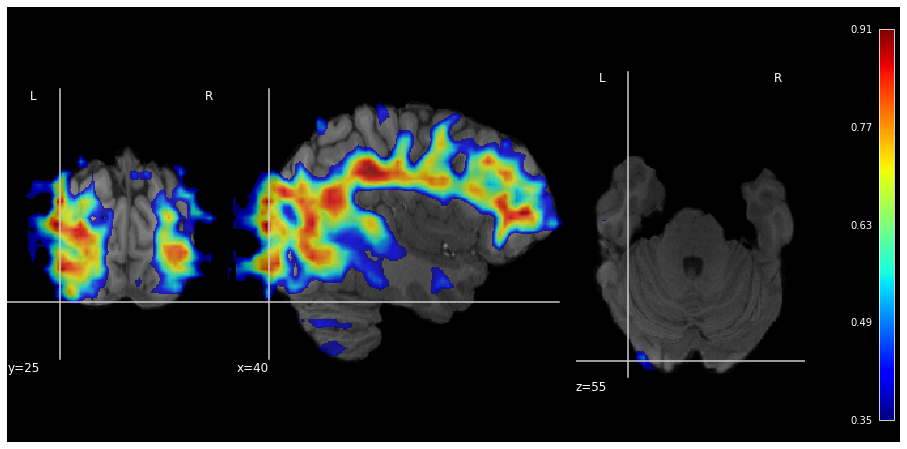

In [33]:
fig, axes = plt.subplots(figsize=(16,8))
roi_img = nib.Nifti1Image(mask[0][0],affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[0][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img, cut_coords = (40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()

# Train mult zero grad_cam

In [15]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
def get_metric_zero_mask(net, data_loader, masks):
    net.eval()
    correct = 0
    true = []
    i = 0
    k = 0
    for data, target in tqdm(data_loader):
        mask_zero = mask[i][k] <=0
        ones_mask = np.ones((mask[i][k].shape))
        ones_mask[mask_zero] = 0
#         data = data.to(device,dtype=torch.float)
#         data = data.mul(torch.from_numpy(mask[i][k])).to(device,dtype=torch.float)
#         print(torch.from_numpy(mask[i][k])[None,None,:,:,:].shape)
#         print(data.shape)
        data = data.mul(torch.from_numpy(ones_mask)[None,None,:,:,:]).to(device,dtype=torch.float)
        target = target.to(device)
#         data = data.to(device)
#         print(data)
        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        true.append(pred.data.cpu().numpy())
        correct += pred.eq(target.data).cpu().sum()
        k +=1
        if k > 127:
            i +=1
            k = 0
        del data, target, out, pred
    accuracy = 100. * correct / len(data_loader.dataset)
    true = np.concatenate(true)
    roc_auc = roc_auc_score(data_loader.dataset.labels, true)
    pr = precision_score(data_loader.dataset.labels,  true)
    rec = recall_score(data_loader.dataset.labels, true)

    return accuracy.item(), roc_auc, pr, rec

In [14]:
model = model.to(device) 
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model__checkpoints_torchio_reshape'), map_location=device))
#     model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'checkpoints_augment_rot_55best_acc_model__checkpoints_augment_18_1.2'), map_location=device))#change path
model.eval()
loader = torch_data.DataLoader(hcp_dataset,
                                          shuffle=False,
                                          batch_size=1)
# mask = []
# i =0
# for each in os.listdir(CHECKPOINTS_DIR):
#     if 'train' in each:
#         mask.append(np.load(os.path.join(CHECKPOINTS_DIR,each)))
#         print(mask[i].shape)
#         i+=1
ac_z, roc_auc_z, pr_z, rec_z = get_metric_zero_mask(model,loader,mask)
print(ac_z, roc_auc_z, pr_z, rec_z)

100%|██████████| 223/223 [04:39<00:00,  1.25s/it]


66.36771392822266 0.662107803700724 0.7058823529411765 0.5454545454545454


# Train mult clean gradcam

In [11]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
def get_metric_mask(net, data_loader, masks):
    net.eval()
    correct = 0
    true = []
    i = 0
    k = 0
    for data, target in tqdm(data_loader):
        data = data.mul(torch.from_numpy(mask[i][k])).to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        true.append(pred.data.cpu().numpy())
        correct += pred.eq(target.data).cpu().sum()
        k +=1
        if k > 127:
            i +=1
            k = 0
        del data, target, out, pred
    accuracy = 100. * correct / len(data_loader.dataset)
    true = np.concatenate(true)
    roc_auc = roc_auc_score(data_loader.dataset.labels, true)
    pr = precision_score(data_loader.dataset.labels,  true)
    rec = recall_score(data_loader.dataset.labels, true)

    return accuracy.item(), roc_auc, pr, rec

In [12]:
model = model.to(device) 
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model__checkpoints_torchio_reshape'), map_location=device))
#     model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'checkpoints_augment_rot_55best_acc_model__checkpoints_augment_18_1.2'), map_location=device))#change path
model.eval()
loader = torch_data.DataLoader(hcp_dataset,
                                          shuffle=False,
                                          batch_size=1)
mask = []
i =0
for each in os.listdir(CHECKPOINTS_DIR):
    if 'train' in each:
        mask.append(np.load(os.path.join(CHECKPOINTS_DIR,each)))
        print(mask[i].shape)
        i+=1
ac_z, roc_auc_z, pr_z, rec_z = get_metric_mask(model,loader,mask)
print(ac_z, roc_auc_z, pr_z, rec_z)

(128, 176, 260, 230)
(128, 176, 260, 230)
(128, 176, 260, 230)
(128, 176, 260, 230)
(128, 176, 260, 230)
(128, 176, 260, 230)
(121, 176, 260, 230)


100%|██████████| 889/889 [07:51<00:00,  1.88it/s]


55.45556640625 0.5012594458438288 1.0 0.0025188916876574307


# Test mult grad_cam

In [16]:
mask = []
i =0
for each in os.listdir(CHECKPOINTS_DIR):
    if 'test' in each:
        mask.append(np.load(os.path.join(CHECKPOINTS_DIR,each)))
        print(mask[i].shape)
        i+=1

(128, 176, 260, 230)
(95, 176, 260, 230)


In [15]:
#val
model = model.to(device) 
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model__checkpoints_torchio_reshape'), map_location=device))
#     model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'checkpoints_augment_rot_55best_acc_model__checkpoints_augment_18_1.2'), map_location=device))#change path
model.eval()
loader = torch_data.DataLoader(hcp_dataset,
                                          shuffle=False,
                                          batch_size=1)
# mask = []
# i =0
# for each in os.listdir(CHECKPOINTS_DIR):
#     if 'test' in each:
#         mask.append(np.load(os.path.join(CHECKPOINTS_DIR,each)))
#         print(mask[i].shape)
#         i+=1
ac, roc_auc, pr, rec = get_metric_perturb_mask(model,loader,mask)
print(ac, roc_auc, pr, rec)

100%|██████████| 223/223 [02:20<00:00,  1.59it/s]

79.37220001220703 0.7916331456154465 0.9210526315789473 0.6363636363636364


# Test mult zero grad_cam

In [19]:
model = model.to(device) 
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model__checkpoints_torchio_reshape'), map_location=device))
#     model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'checkpoints_augment_rot_55best_acc_model__checkpoints_augment_18_1.2'), map_location=device))#change path
model.eval()
loader = torch_data.DataLoader(hcp_dataset,
                                          shuffle=False,
                                          batch_size=1)
ac_z, roc_auc_z, pr_z, rec_z = get_metric_zero_mask(model,loader,mask)
print(ac_z, roc_auc_z, pr_z, rec_z)

100%|██████████| 223/223 [01:38<00:00,  2.27it/s]

95.96412658691406 0.9598149637972647 0.9469026548672567 0.9727272727272728


# Test mult clean gradcam

In [12]:
model = model.to(device) 
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model__checkpoints_torchio_reshape'), map_location=device))
#     model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'checkpoints_augment_rot_55best_acc_model__checkpoints_augment_18_1.2'), map_location=device))#change path
model.eval()
loader = torch_data.DataLoader(hcp_dataset,
                                          shuffle=False,
                                          batch_size=1)
mask = []
i =0
for each in os.listdir(CHECKPOINTS_DIR):
    if 'test' in each:
        mask.append(np.load(os.path.join(CHECKPOINTS_DIR,each)))
        print(mask[i].shape)
        i+=1
ac_z, roc_auc_z, pr_z, rec_z = get_metric_mask(model,loader,mask)
print(ac_z, roc_auc_z, pr_z, rec_z)

(128, 176, 260, 230)


  0%|          | 0/223 [00:00<?, ?it/s]

(95, 176, 260, 230)


100%|██████████| 223/223 [01:33<00:00,  2.39it/s]

50.672645568847656 0.5 0.0 0.0



/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
def get_metric(net, data_loader):
    net.eval()
    correct = 0
    true = []
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)
        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        true.append(pred.data.cpu().numpy())
        correct += pred.eq(target.data).cpu().sum()
        del data, target, out, pred
    accuracy = 100. * correct / len(data_loader.dataset)
    true = np.concatenate(true)
    roc_auc = roc_auc_score(data_loader.dataset.labels, true)
    pr = precision_score(data_loader.dataset.labels,  true)
    rec = recall_score(data_loader.dataset.labels, true)

    return accuracy.item(), roc_auc, pr, rec

In [16]:
#train
model = model.to(device) 
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model__checkpoints_torchio_reshape'), map_location=device))
#     model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'checkpoints_augment_rot_55best_acc_model__checkpoints_augment_18_1.2'), map_location=device))#change path
model.eval()
loader = torch_data.DataLoader(hcp_dataset,
                                          shuffle=False,
                                          batch_size=1)
ac_z, roc_auc_z, pr_z, rec_z = get_metric(model,loader)
print(ac_z, roc_auc_z, pr_z, rec_z)

100%|██████████| 889/889 [04:50<00:00,  3.06it/s]

98.4251937866211 0.985285986361123 0.9705159705159705 0.9949622166246851


In [12]:
#test
model = model.to(device) 
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model__checkpoints_torchio_reshape'), map_location=device))
#     model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'checkpoints_augment_rot_55best_acc_model__checkpoints_augment_18_1.2'), map_location=device))#change path
model.eval()
loader = torch_data.DataLoader(hcp_dataset,
                                          shuffle=False,
                                          batch_size=1)
ac_z, roc_auc_z, pr_z, rec_z = get_metric(model,loader)
print(ac_z, roc_auc_z, pr_z, rec_z)

100%|██████████| 223/223 [01:06<00:00,  3.36it/s]

97.30941772460938 0.9734513274336284 0.9482758620689655 1.0


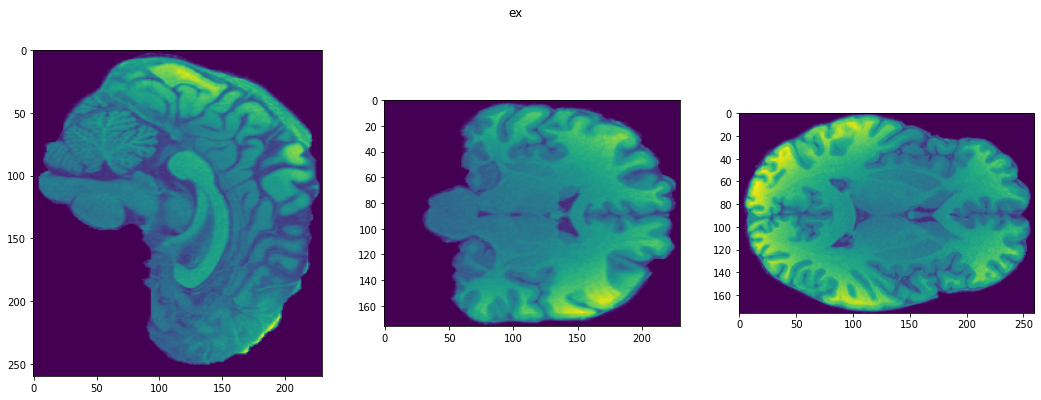

In [36]:
plot_central_cuts(hcp_dataset[1][0], title="ex", t = None)

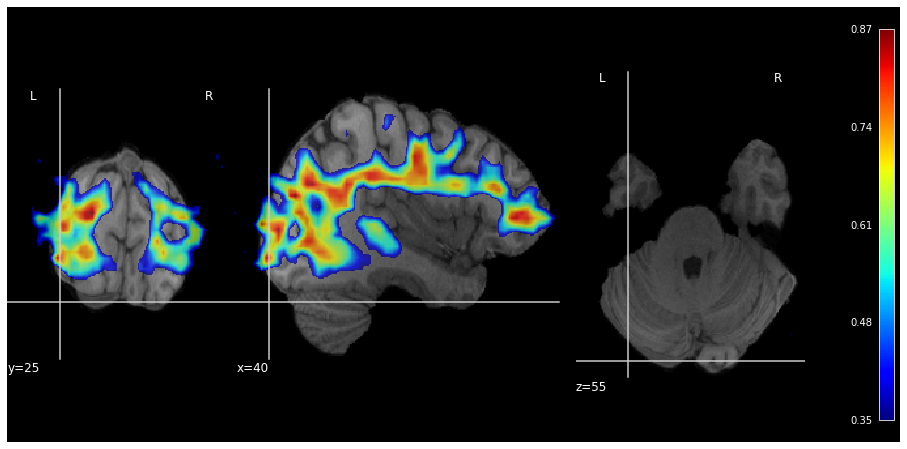

In [27]:
#check
ex1 = mask[1][0]
fig, axes = plt.subplots(figsize=(16,8))
roi_img = nib.Nifti1Image(ex1,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[1][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img, cut_coords = (40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()

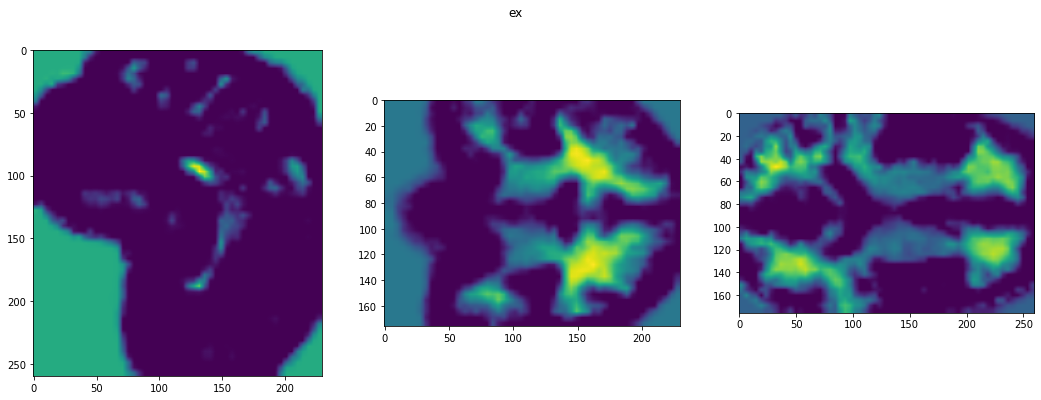

In [28]:
plot_central_cuts(torch.from_numpy(ex1)[None,:,:,:], title="ex", t = None)

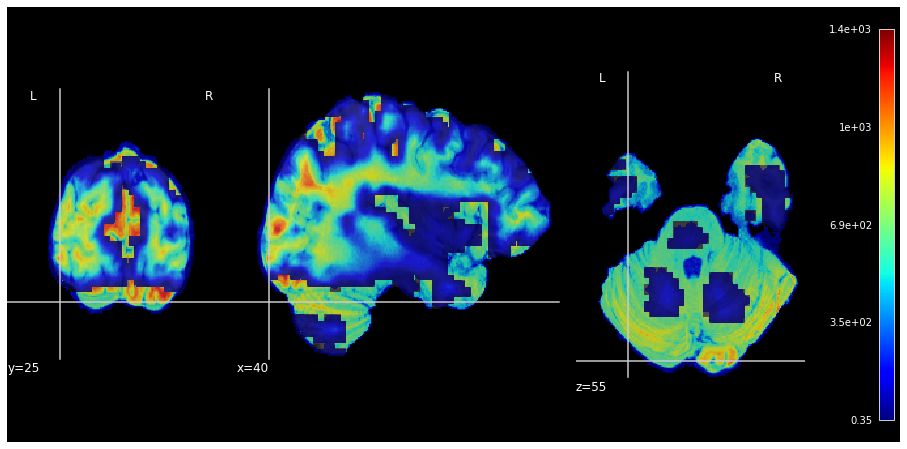

In [44]:
#gradcam
ex3 = mask[1][0]
ex3[ex3 == 0] =1
ex3 = hcp_dataset[1][0].mul(torch.from_numpy(ex3)[None,None,:,:,:])
        
fig, axes = plt.subplots(figsize=(16,8))
roi_img = nib.Nifti1Image(np.squeeze(ex3.numpy()),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[1][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img, cut_coords = (40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()

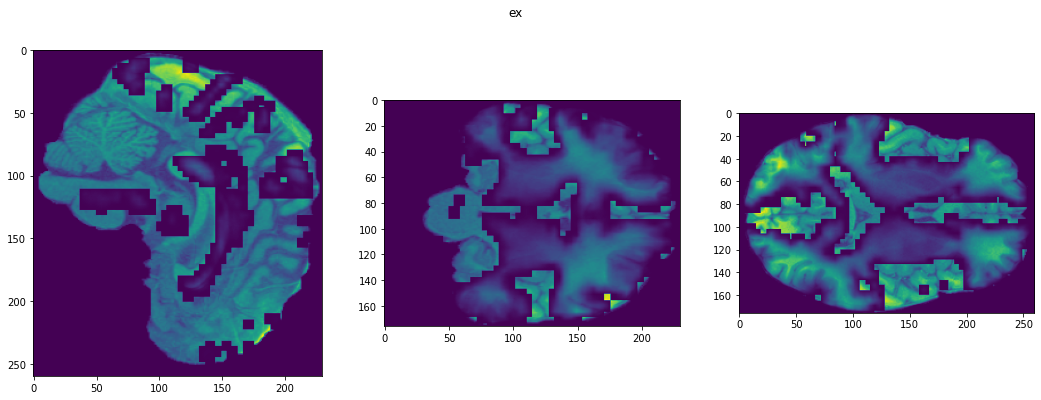

In [45]:
plot_central_cuts(np.squeeze(ex3, axis=0), title="ex", t = None)

In [52]:
ex3 = mask[1][0]
ex3[ex3 == 0] =1
l = hcp_dataset[1][0].mul(torch.from_numpy(ex3)[None,None,:,:,:])

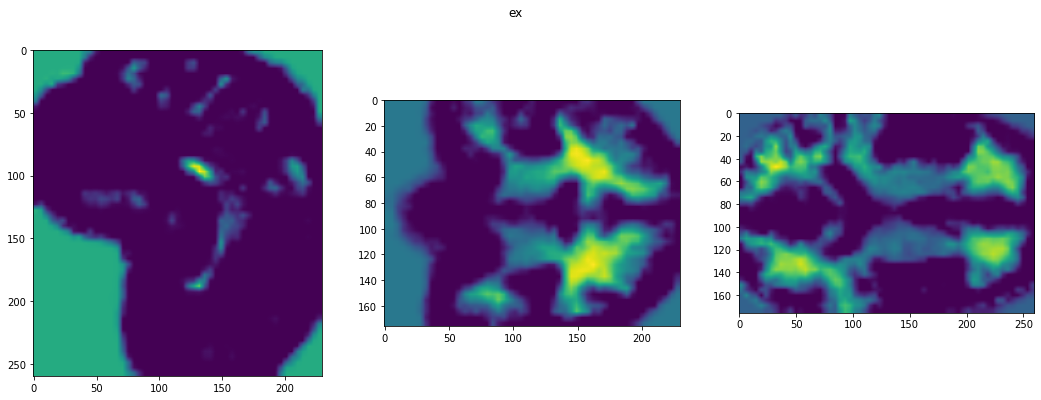

In [50]:
plot_central_cuts(torch.from_numpy(mask[1][0])[None,:,:,:], title="ex", t = None)

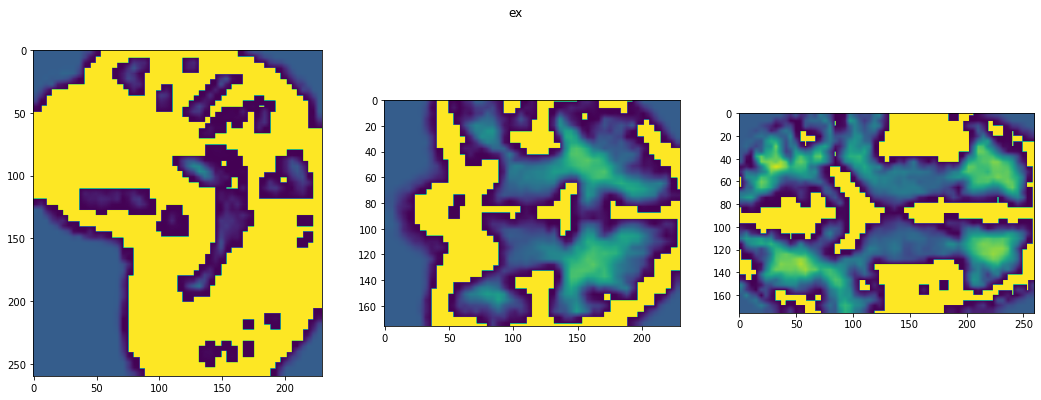

In [53]:
plot_central_cuts(torch.from_numpy(ex3)[None,:,:,:], title="ex", t = None)

In [55]:
l = hcp_dataset[1][0].mul(torch.from_numpy(ex3)[None,None,:,:,:])

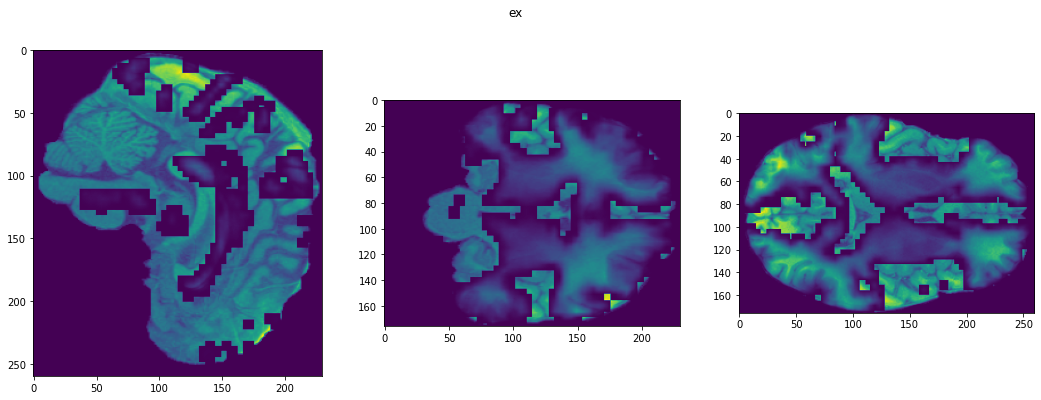

In [56]:
plot_central_cuts(np.squeeze(l, axis=0), title="ex", t = None)

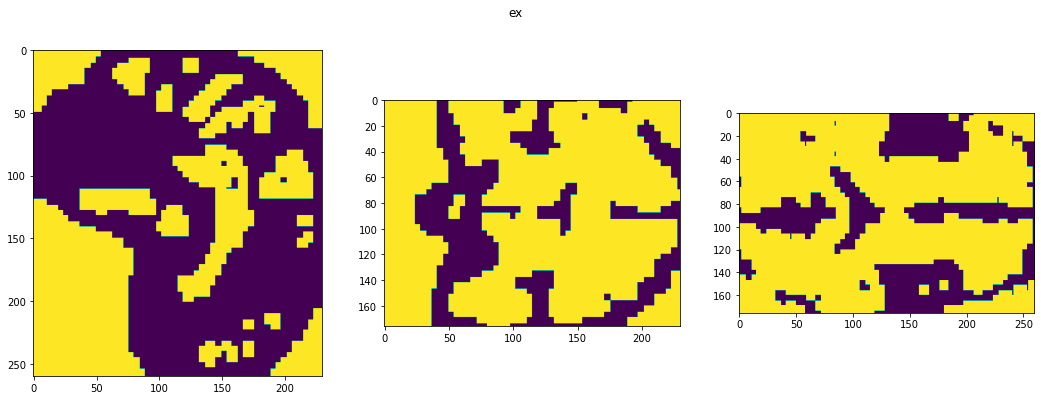

In [21]:
ex2 = mask[1][0] 
mask_zero = ex2 <=0
ones_mask = np.ones((ex2.shape))
ones_mask[mask_zero] = 0
plot_central_cuts(torch.from_numpy(ones_mask)[None,:,:,:], title="ex", t = None)

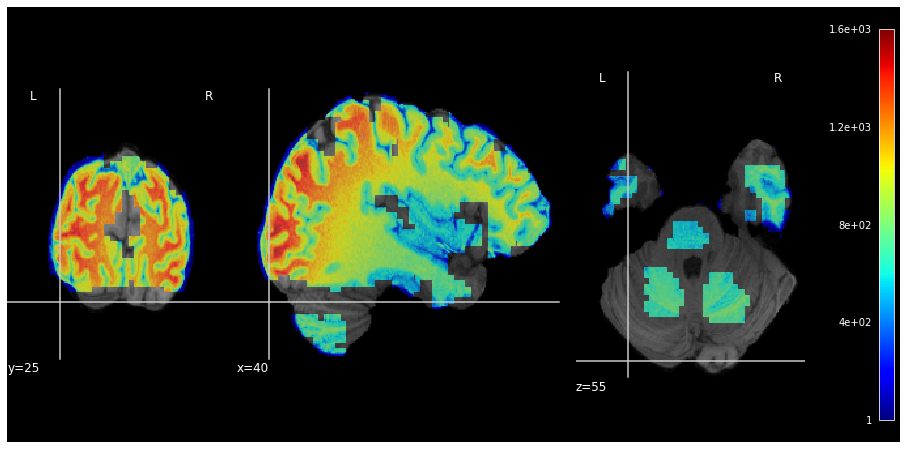

In [22]:
ex2 = hcp_dataset[1][0].mul(torch.from_numpy(ones_mask)[None,None,:,:,:])
        
fig, axes = plt.subplots(figsize=(16,8))
roi_img = nib.Nifti1Image(np.squeeze(ex2.numpy()),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[1][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img, cut_coords = (40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()

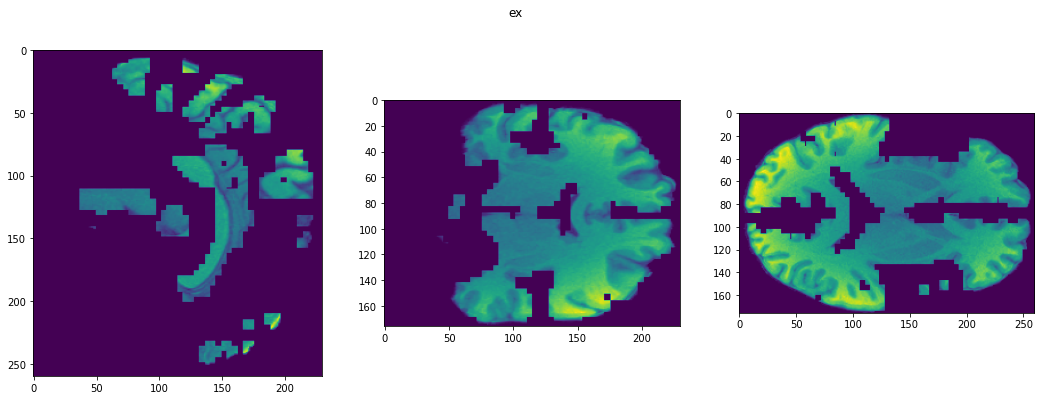

In [23]:
plot_central_cuts(np.squeeze(ex2, axis=0), title="ex", t = None)

# Create binary mask

In [ ]:

for each in os.listdir(CHECKPOINTS_DIR):
    if 'fold_0' in each:
        mask = np.load(os.path.join(CHECKPOINTS_DIR,each))
        for i in mask:
            mask[mask <=0.35] =0
               